# Advanced Lane Detection
 
 This is for project 2, of Udacity's SDC ND. In this lanes needs to be marked on road from given video. In the given clip there many variations and hard conditions like Left and right curves on road, road repairs markings with the lane, shadow of tress on lane markings, different type of roads (tar to concrete and back to tar) and tire marks on road.
 
 To handle this a pipeline with following steps is created: 
  - Camera Calibration: As real world images and camera images are not same this is required to undo camera's distortion
  - Bird Eye View: A top-down view gives better look at lanes which in turn helps to mark them properly.
  - Color space transformation: We see world in RGB color format but with digital images we can use many color spaces (like HLS/HSV/Lab) which helps to find things generally not visible with normal eyes
  - Lane pixels: After above steps, we get a binary image with lane pixels activated on it. 
  - Radius of curve and Vehicle position: Fit curve on activated pixels, based on that find position of vehicle on lane.
  - Mark lanes in processed image
  - Undo Bird's eye view and post same on original image.
  - Write it to a file.
   
 

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import os
from PIL import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib qt
%matplotlib inline

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# Constants and Variables

In [2]:
"""
This cell contains all constants and variables to be used  during pipeline.
"""

"""
Camera distortion Matrix, these are required to transform camera images to real world images
using calibration images.
"""
cam_matrix = 0.0
cam_distortion = 0.0

"""
Bird's eye transformation needs a matrix to convert given points to desired points. 
Inverse of same is used to undo transformation.
"""
M = 0.0
Minv = 0.0

"""
Points used for transforming given image to birds eye view. SRC is points on given image and
DST is how they should be mapped in transformed image.
After experiments and googling found these params work best.
"""
src = np.float32([(220,720),
                  (1110, 720), 
                  (570, 470), 
                  (722, 470)])
dst = np.float32([(320,720),
                  (920, 720),
                  (320, 1),
                  (920, 1)])

"""
For radius of curvature of lanes we need to map pixels to meters.
Distance between lanes is 3.7 meters and is about 700 pixels while for
lenght it is 30 meters and pixel length is about 720 pixles.
This is as it is from course.
"""
ym_per_pix = 30/720 
xm_per_pix = 3.7/700

"""
To find lanes on processed image, as sliding window protocol is used.
These are hyper parameters for that. 
"""
nwindows = 9
margin = 125
minpix = 50

"""
These are temporary place holders for fitting cures of lanes.
"""
left_fit_mean = []
right_fit_mean = []
left_fit_mean_m = []
right_fit_mean_m = []
len_prev_store = 5


"""
Constants for image/video locations
"""
test_cam_cal_glob = glob.glob('c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/camera_cal/*.jpg')
test_img_given_glob = glob.glob('c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/test_images/*.jpg') 

test_frame_challange_glob = glob.glob('c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/frames/original/*.jpg') 


proj_video = "c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/project_video.mp4"
proj_challange_video = "c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/challenge_video.mp4"
proj_hard_challange_video = "c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/harder_challenge_video.mp4"

proj_video_out = "c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/output_images/project_video.mp4"
proj_challange_video_out = "c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/output_images/challenge_video.mp4"
proj_hard_challange_video_out = "c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/output_images/harder_challenge_video.mp4"


In [3]:
def calibrate_camera_params(test_cam_cal_glob = test_cam_cal_glob):
    """
    Inputs:
        test_cam_cal_glob: List of file names given for camera caliration.
    Outputs:
        Instead of return, dump camera parmeters to a pickle file which can be read anytime.
    
    Functionality:
        This function processes a list of images which have well defined corners. 
        cv2.findChessboardCorners tries to fit those corners and return a list if they are found properly.
        cv2.calibrateCamera tries to fit corners from actual (physical world) to one found in image. It returns
        camera matrix and distortion coefficients.
        This also saves camera coefficients to a pickle file.
    """
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    camera_calib = test_cam_cal_glob
    for idx, fname in enumerate(camera_calib):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners in given image
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        # If found, add object points, image points
        if ret == True:
                
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            plt.imshow(img)
            
    cam_test_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, cam_test_size,None,None)
        
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "./pickle/cam_mtx_dist.p", "wb" ) )
    


In [4]:
def get_cam_params():
    """
    Inputs: None
    
    Outputs: 
        Camera coefficients
    
    Functionality: 
        loads Camera coefficients to required global place holders
    """
    cameraCalibration = pickle.load( open('./pickle/cam_mtx_dist.p', 'rb' ) )

    return map(cameraCalibration.get, ('mtx', 'dist'))

In [5]:
def get_wrap_params():
    """
    Inputs: None
    
    Outputs: 
        Matrix required to transform image to top down view and view-versa
    
    Functionality: 
        loads transformation matrix to required global place holders
    """
    cameraCalibration = pickle.load( open('./pickle/unwrap.p', 'rb' ) ) 

    return map(cameraCalibration.get, ('M', 'Minv'))

In [6]:
def display_iamges_glob(images ,cols = 4, rows = 5, figsize=(20,20), cmap = None):
    """
    Inputs:
        images: Glob file for images to be displayed
        cols: cols in required display
        rows: rows in required display
        figsize:  figure size of diaplay
        cmap:  color map to be used while plotting image
    Outputs:
        None
    Functionality:
        This function is used to display images after some type of processing is done.
    """
    rows = rows 
    cols = cols
    i = 0
    if (len(images) != rows * cols):
        print("Not enough images to fill all rows and cols")
        return
    f, ax = plt.subplots(rows, cols, figsize=figsize)
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(mpimg.imread(images[i]),cmap=None)
            ax[r, c].set_title('{}'.format(images[i].split('\\')[-1]))
            ax[r, c].axis('off')
            i += 1

In [7]:
def display_iamges_list(img_list , figsize=(50,50), cmap = None):
    """
    Inputs:
        img_list: A list of images that needs to be displayed. 
        figsize:  figure size of diaplay.
        cmap:  color map to be used while plotting image
    Outputs:
        None
    Functionality:
        This function is used to display images after some type of processing is done.
    """
    rows = int(len(img_list)/2)
    cols = 2
    #print(rows, cols)
    f, ax = plt.subplots(rows, cols, figsize=figsize)
    for r in range(rows):
        for c in range(cols):
            if c == 0:
                ax[r, c].imshow(img_list[r+c],cmap=None)
            else:
                ax[r, c].imshow(img_list[r+c + rows -1],cmap=None)
            #ax[r, c].set_title('{}'.format(images[i].split('\\')[-1]))
            ax[r, c].axis('off')

In [8]:
def display_hist_list(img_list , figsize=(50,50), cmap = None):
    """
    Inputs:
        img_list: A list of images that needs to be displayed. 
        figsize:  figure size of diaplay.
        cmap:  color map to be used while plotting image
    Outputs:
        None
    Functionality:
        This function is used to display histograms after some type of processing is done.
    """
    rows = int(len(img_list)/2)
    cols = 2
    #print(rows, cols)
    f, ax = plt.subplots(rows, cols, figsize=figsize)
    for r in range(rows):
        for c in range(cols):
            if c == 0:
                ax[r, c].plot(img_list[r+c])
            else:
                ax[r, c].plot(img_list[r+c + rows -1])
            #ax[r, c].set_title('{}'.format(images[i].split('\\')[-1]))
            ax[r, c].axis('off')

In [9]:
def display_images_list_lane(img_list, left_x, right_x, ploty_list,figsize=(50,50)):
    """
    Inputs:
        img_list: A list of images that needs to be displayed. 
        left_x: list of X-coordinates for left side of lane
        right_x: list of X-coordinates for right side of lane
        ploty_list: list of Y-coordinates to be used with X-coordinates while ploting
        figsize: figure size
    Outputs:
        None
    Functionality:
        Displays top-down view of processed image with lanes marked properly on it.
    """    
    rows = int(len(img_list))
    #print(rows, cols)
    f, ax = plt.subplots(rows, figsize=figsize)
    for r in range(rows):
        ax[r].imshow(img_list[r],cmap=None)
        ax[r].plot(left_x[r],ploty_list[r],color='yellow')
        ax[r].plot(right_x[r],ploty_list[r],color='blue')
            
    #ax[r, c].set_title('{}'.format(images[i].split('\\')[-1]))
   # ax[r, c].axis('off')

In [10]:
## set cam params and distortion params
cam_matrix, cam_distortion = get_cam_params()

In [11]:
def wrap_top_down_image(img,src, dst):
    """
    Inputs:
        img: Image which has to be transformed from normal view to Bird's eye view
        src: Source points that needs to be marked while transformation
        dst: Destination points that needs to marked in processed image
    Outputs:
        None
    Functionality:
        This function transforms points given on image to a formation which is top-down view of 
        required segment. Generally this helps to get a better view of lanes on road. 
        Also save required transformation Matrix to a pickle file from which it can be read later.
    """    
    height, width = img.shape[0],img.shape[1]
    img = cv2.undistort(img, cam_matrix, cam_distortion, None, cam_matrix)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    wrap_pickle = {}
    wrap_pickle["M"] = M
    wrap_pickle["Minv"] = Minv
    pickle.dump( wrap_pickle, open( "./pickle/unwrap.p", "wb" ) )
    
    warped = cv2.warpPerspective(img, M, (width,height), flags=cv2.INTER_LINEAR)
    return warped

In [12]:
def get_sobel(image,s_thresh=(100, 255), sx_thresh=(10, 100), R_thresh = (200, 255), sobel_kernel = 3 ):
    """
    Inputs:
        img: Image on which we need to apply sobel and color transformation 
        s_thresh: Threshold for S Channel in HLS
        sx_thresh: Threshold for L Channel sobel in HLS
        R_thresh: Threshold for R Channel in RGB
        sobel_kernel: Size of kernel that needs to applied while calculating sobel X and Y
    Outputs:
        A image with lanes pixels actiavted on it. It is top-down view of road.
    Functionality:
        This functions calculates sobel transformation on L channel of HLS in X direction and convert it to binary.
        On S channel (of HLS) and R channel (of RGB)it creats a binary image based on threshold.
        After this it takes a vote of 2 out 3 for activating a pixel in processed image.
        This is copied to all three channels and multipled by 255 to give black and white processed image.
    """           
    Red = image[:,:,0]
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) 
             & (scaled_sobelx <= sx_thresh[1])] = 1

    # Threshold R color channel
    R_binary = np.zeros_like(Red)
    R_binary[(Red>= R_thresh[0]) & (Red <= R_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # If two of the three are activated, activate in the binary image
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) & (sxbinary == 1)) 
                     | ((sxbinary == 1) & (R_binary == 1))
                     | ((s_binary == 1) & (R_binary == 1))] = 1

    #return combined_binary
    #np.dstack((combined_binary, combined_binary, combined_binary)) * 255
    return np.dstack((combined_binary, combined_binary, combined_binary)) * 255 
    #return np.dstack(((s_binary), s_binary, s_binary)) * 255
    #return np.dstack((s_binary, s_binary, s_binary)) * 255

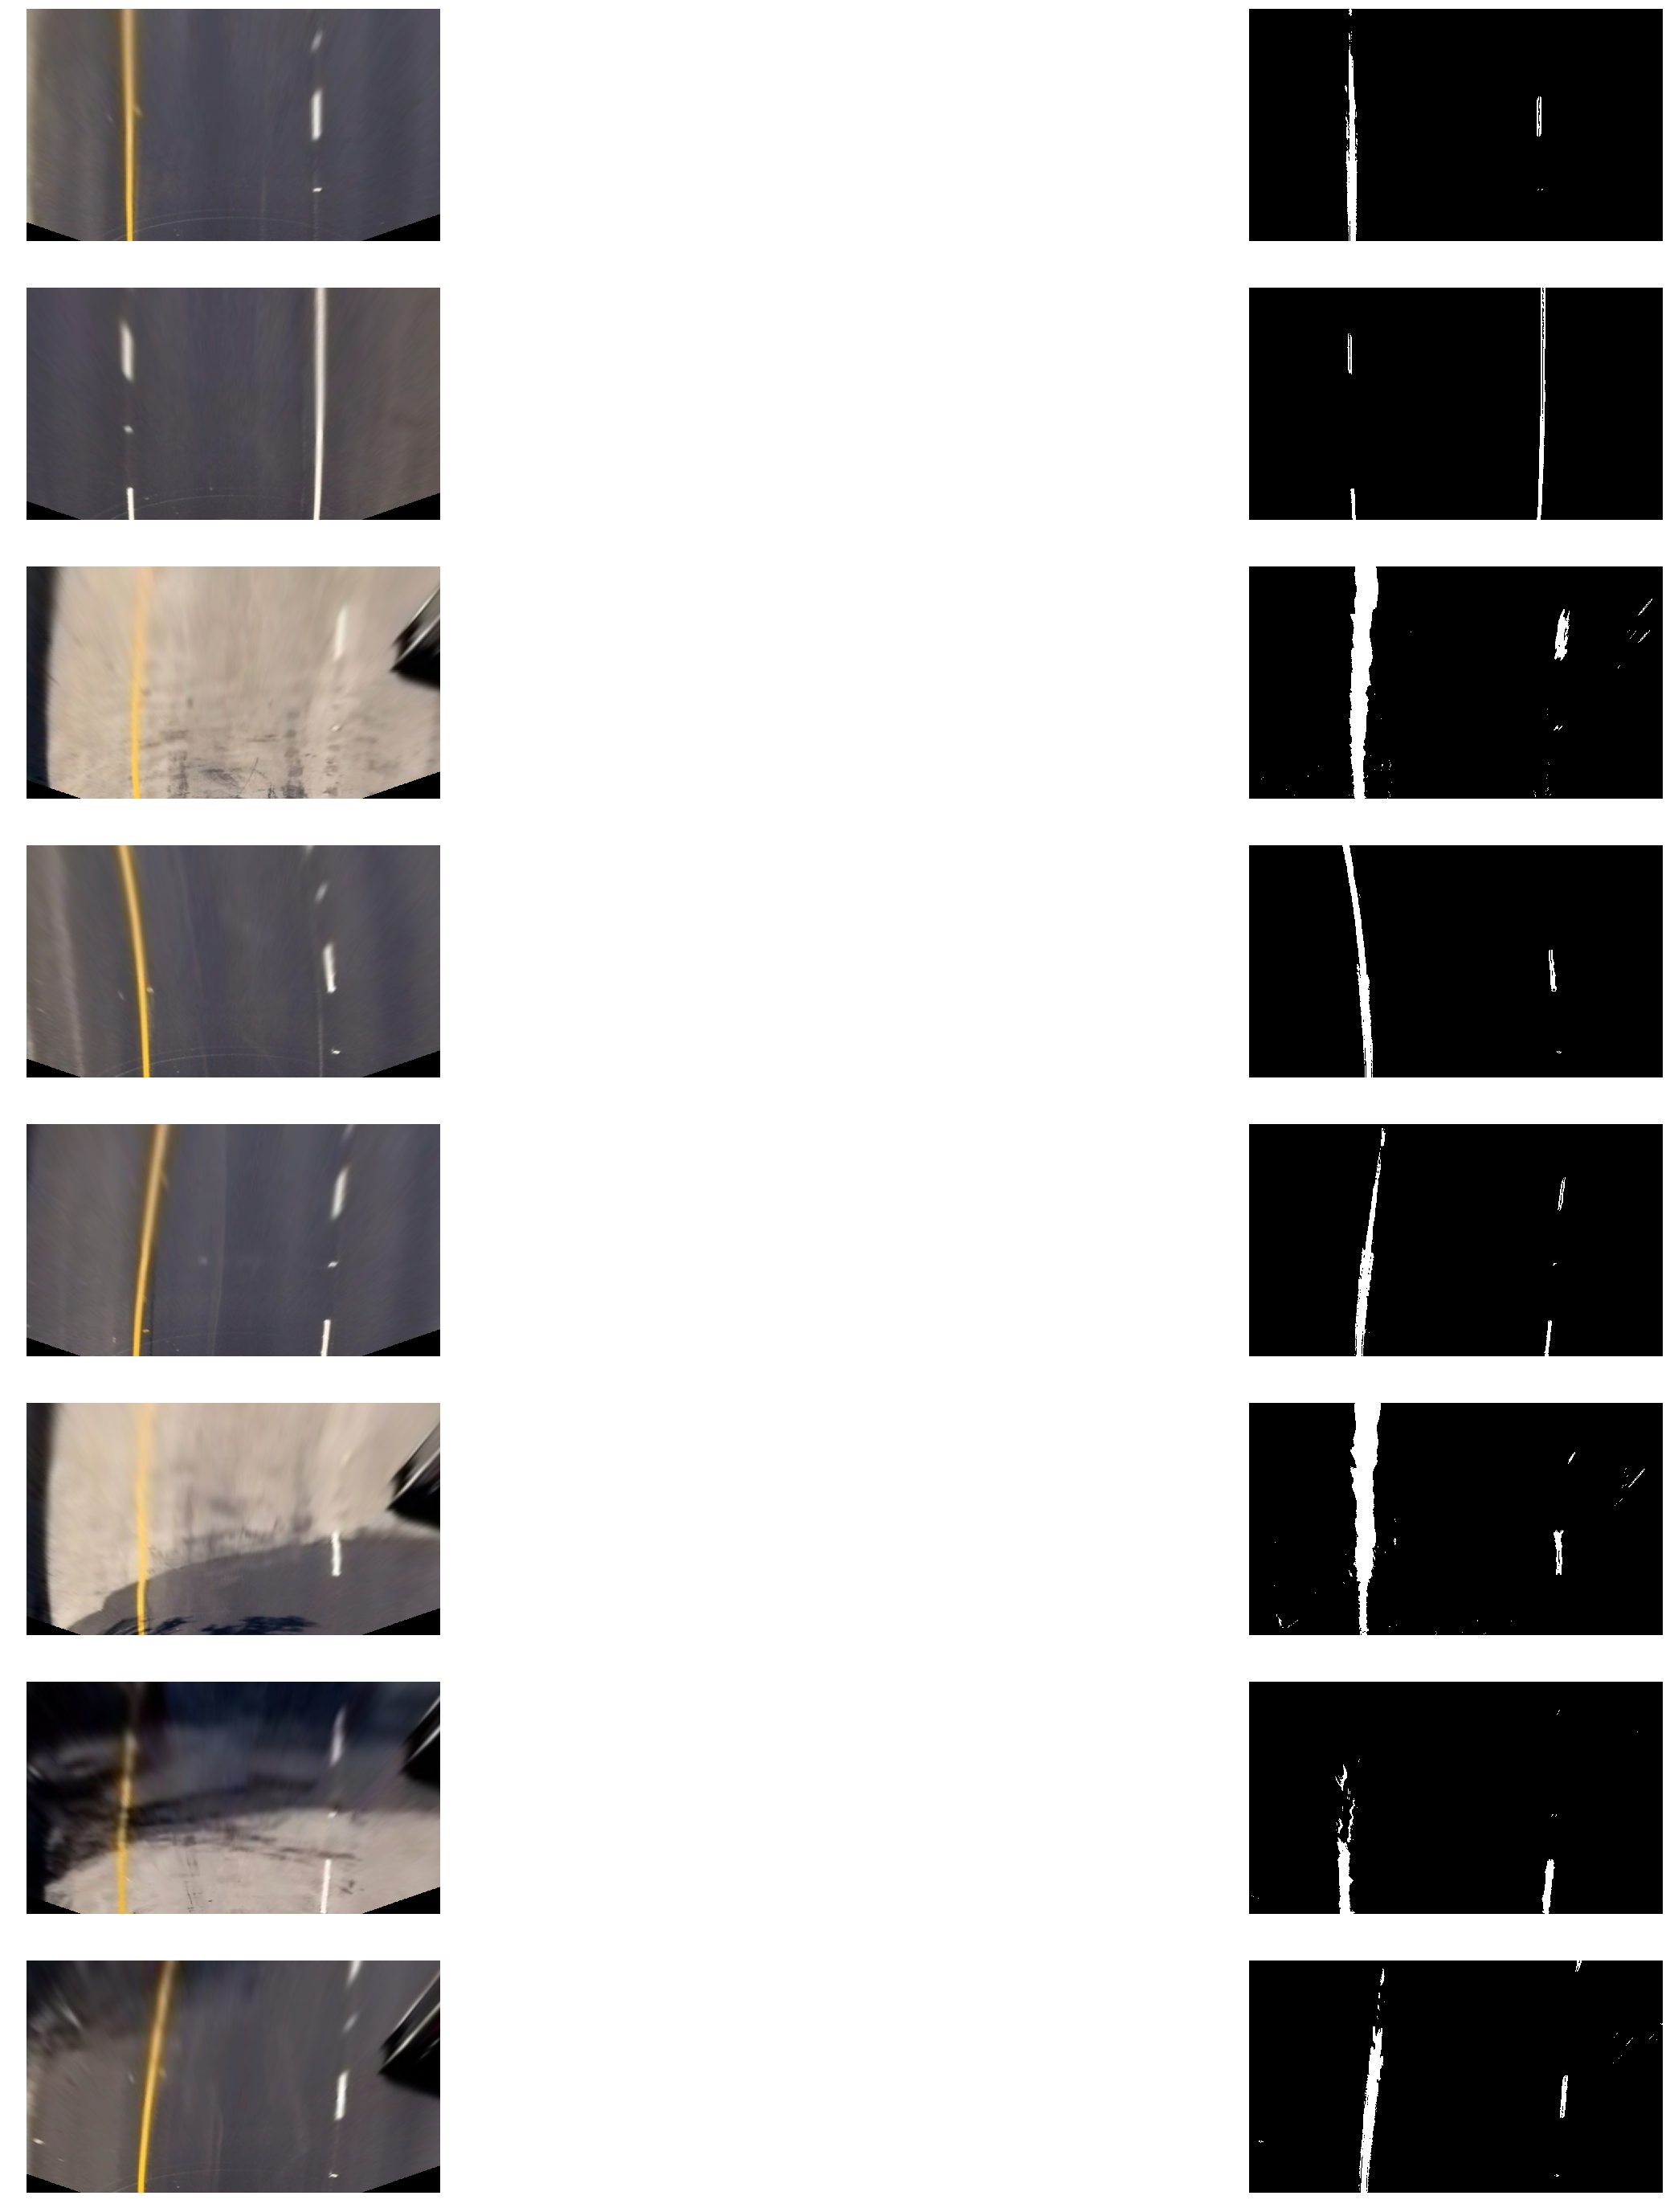

In [13]:
def test_wrap_top_down_image():
    """
    Inputs:
       None
    Outputs:
        Plot of top-down view of required segment with corresponding processed image with activated lane pixels
    Functionality:
        This function tests wrap_top_down_image and get_sobel with given test images.
    """   
    images = []
    images_sobel = []
    
    for idx, fname in enumerate(test_img_given_glob):
        img = mpimg.imread(fname)
                
        #sobel = get_sobel_1(img)
        warped = wrap_top_down_image(img,src, dst)
        sobel = get_sobel(warped)
        images.append(warped)
        images_sobel.append(sobel)
    all_img = images + images_sobel
    display_iamges_list(all_img)


test_wrap_top_down_image()

In [14]:
def image_hist(img): 
    """
    Inputs:
       img : Image with activated pixels for lane marking.
    Outputs:
        A histogram of activated pixels in X direction 
    Functionality:
        This function calculates number of actiavted pixels in Y direction for given X value
    """  
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    return histogram

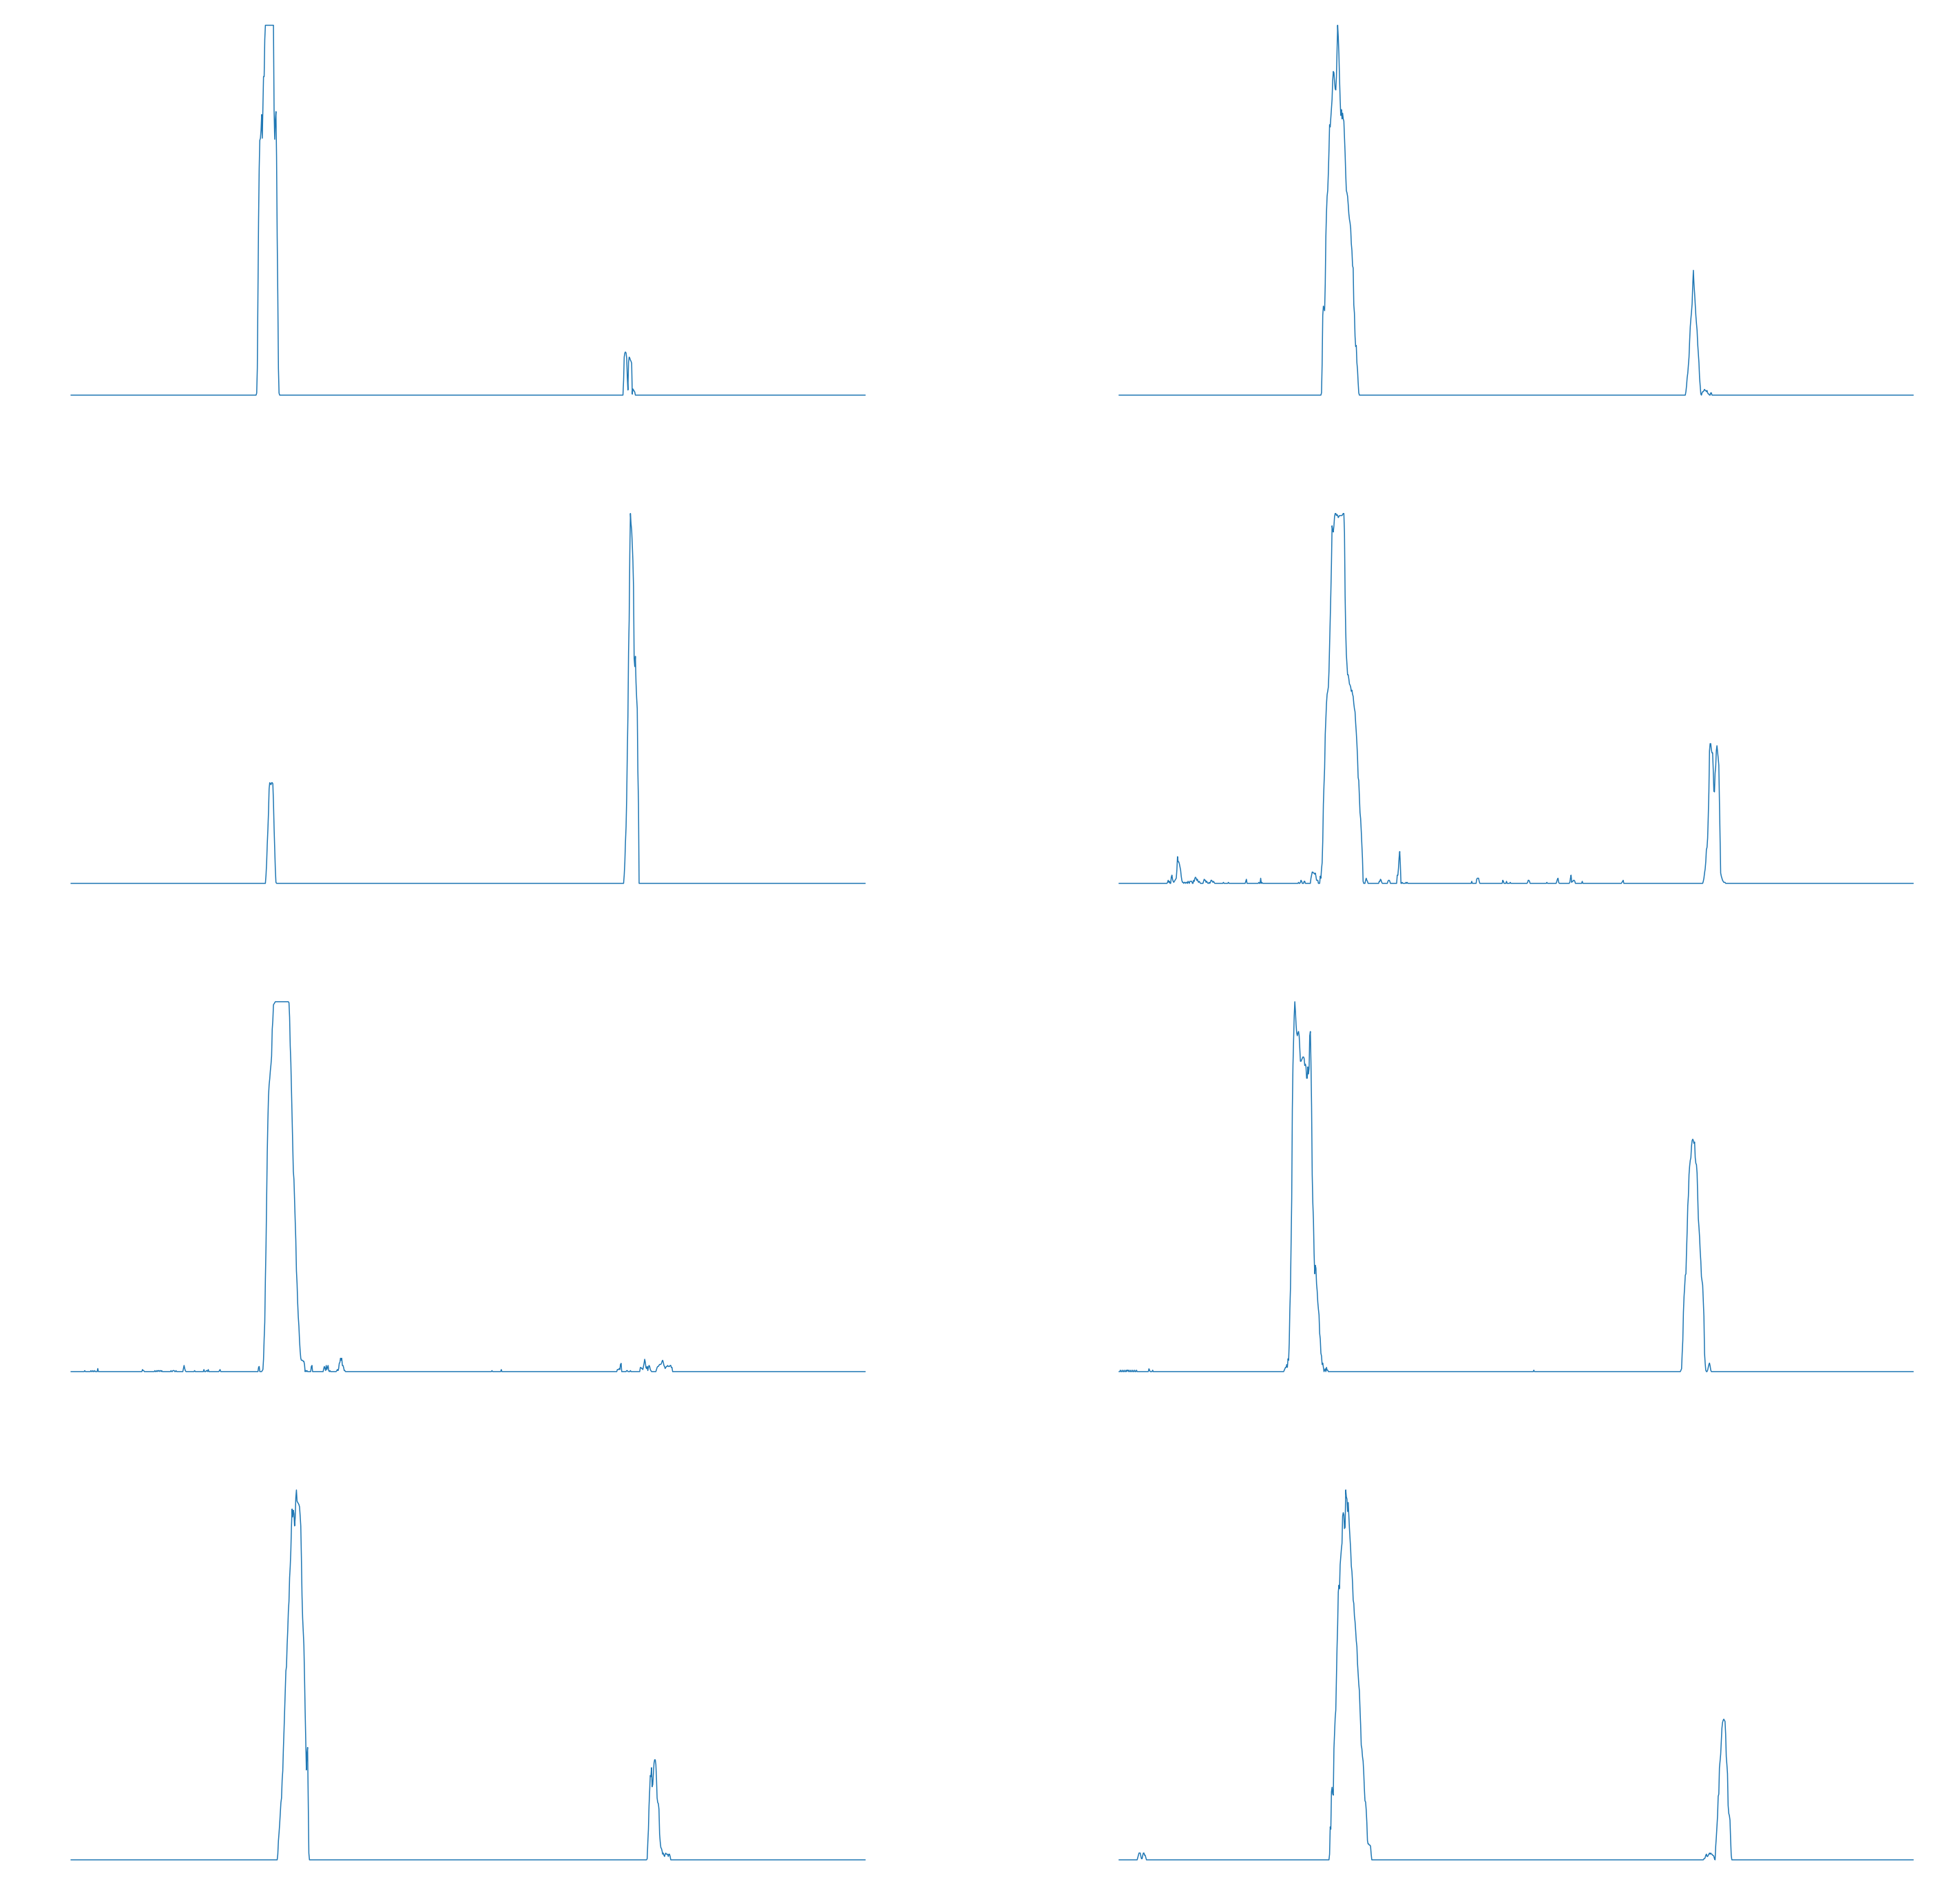

In [15]:
def test_image_hist():
    """
    Inputs:
       None
    Outputs:
        Plot of histograms for test actiavted lane pixel images
    Functionality:
        This function tests image_hist given test images.
    """ 
    images = []
    hist = []
    
    for idx, fname in enumerate(test_img_given_glob):
        img = mpimg.imread(fname)
        warped = wrap_top_down_image(img,src, dst)
        sobel = get_sobel(warped)
        # Sobel return 3 layers and all are same
        hist_img = image_hist(sobel[:,:,1])
        hist.append(hist_img)
    display_hist_list(hist)

test_image_hist()
        

In [16]:
## load Transformation matrix to/from top-down to normal original image
M,Minv = get_wrap_params()


In [17]:
def find_lane_pixels(binary_img):
    """
    Inputs:
       binary_img : Image with activated pixels for lanes.
    Outputs:
        leftx: List of X-Coordinates for left lane
        lefty: List of Y-Coordinates for left lane
        rightx: List of X-Coordinates for right lane
        righty: List of Y-Coordinates for right lane
        out_img: Given image with rectangles marked for left and right lane. 
        dominant_lane: Lane which has more activated pixels.
    Functionality:
        This function marks rectangles starting from bottom having minpix activated for lanes. 
        It is then repeated till top and postion for starting point is changed based on average 
        of last found points for both left and right lanes. This creates a slidding window for
        finding lanes on given activated image.
        
        Added a hack "dominant_lane" for future improvemnt. With this in some cases when there is sharp turn
        or improper/washed off dashed lane lines we can use detected lane to find other side of lane have to
        parallel and they are about 3.7 meters apart of each other. So if we have found just one lane we can
        calculate the other side of lane. Moreover in normal use case as well we can exploit this to double
        confirm lane markings.
    """  
    hist_img = image_hist(binary_img)
    midpoint = np.int(hist_img.shape[0]//2)
    leftx_base = np.argmax(hist_img[:midpoint])
    rightx_base = np.argmax(hist_img[midpoint:]) + midpoint

    if np.argmax(hist_img) >= midpoint:
        dominant_lane = "Right"
    else:
        dominant_lane = "Left"
    
    
    out_img = np.dstack((binary_img, binary_img, binary_img))
    
    window_height = np.int(binary_img.shape[0]//nwindows)
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base
    
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_img.shape[0] - (window+1)*window_height
        win_y_high = binary_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        print("some error in concatenate")

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img, dominant_lane


In [18]:
def fit_polynomial(img):
    """
    Inputs:
       img : Image in RGB format on which lanes need to be marked.
    Outputs:
        out_img :  Binary actiavted image with sliding rectangles and lanes marked.
        left_fitx : list of X-coordinates for left side of lane
        right_fitx : list of X-coordinates for right side of lane
        left_curverad : Curvature of left lane
        right_curverad : Curvature of right lane
        left_fit : Equation Curvature of left lane
        right_fit : Equation Curvature of right lane
        ploty : list of Y-coordinates to be used with X-coordinates while ploting
        left_fit_m : Equation Curvature of left lane with X and Y in meters
        right_fit_m : Equation Curvature of right lane with X and Y in meters
        
    Functionality:
        This function gets RGB image and then processes it to find lanes on binary activated image.
        It uses find_lane_pixels get list of coordinates for left and right lane. After getting lane
        coordinates it tries to fit a 2nd degree curve (X = A*Y**2 + B*Y + C) on it. Using this curve
        it calculates position of pixels that needs to be actiated for lane on line. This will join
        any breaks in lane lines or extrapolate lanes if they are very short. It also calculates curve 
        for left and right lane using (((1 + (2*A*Y + B)**2)**1.5)/(abs(2*A))).
        It also calculates curve in meters to display on final image.
    """     
    warped = wrap_top_down_image(img,src, dst)
    sobel = get_sobel(warped)
    # Sobel return 3 layers and all are same
    binary_warped = sobel[:,:,1]
    error_left = False
    error_right = False
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, dominant_lane = find_lane_pixels(binary_warped)
    #print(dominant_lane)
    #print(len(leftx))
    #print(len(rightx))
    #print(len(lefty))
    #print(len(righty))
    # Fit a second order polynomial to each using `np.polyfit`
    #try:
    #    left_fit = np.polyfit(lefty , leftx , 2)
    #    left_fit_mean.append(left_fit)
    #except (TypeError, np.linalg.LinAlgError):
    #    error_left = True
    #    print("got some error in left")   
    #
    #try:
    #    right_fit = np.polyfit(righty , rightx , 2)
    #    right_fit_mean.append(right_fit)
    #except (TypeError, np.linalg.LinAlgError):
    #    error_right = True
    #    print("got some error in right")   
 #
    #if len(right_fit_mean) >= len_prev_store:
    #    right_fit_mean.pop(0)
    #if len(left_fit_mean) >= len_prev_store:
    #    left_fit_mean.pop(0)
    #
    #if error_left and error_right:
    #    left_fit = np.mean(left_fit_mean, axis = 0)
    #    right_fit = np.mean(right_fit_mean, axis = 0)
    #if error_left:
    #    #left_fit = np.mean(left_fit_mean, axis = 0)
    #    left_fit = right_fit
    #if error_right:
    #    #right_fit = np.mean(right_fit_mean, axis = 0)
    #    right_fit = left_fit
    
    try:
        left_fit = np.polyfit(lefty , leftx , 2)
        right_fit = np.polyfit(righty , rightx , 2)
        
        left_fit_m = np.polyfit(lefty*ym_per_pix , leftx*xm_per_pix , 2)
        right_fit_m = np.polyfit(righty *ym_per_pix, rightx*xm_per_pix , 2)
        
        right_fit_mean.append(right_fit)
        left_fit_mean.append(left_fit)
        left_fit_mean_m.append(left_fit_m)
        right_fit_mean_m.append(right_fit_m)
        
        if len(right_fit_mean) >= len_prev_store:
            right_fit_mean.pop(0)
        if len(left_fit_mean) >= len_prev_store:
            left_fit_mean.pop(0)
        if len(left_fit_mean_m) >= len_prev_store:
            left_fit_mean_m.pop(0)
        if len(right_fit_mean_m) >= len_prev_store:
            right_fit_mean_m.pop(0)
    except (TypeError, np.linalg.LinAlgError):
        print("got some error")
        left_fit = np.mean(left_fit_mean, axis = 0)
        right_fit = np.mean(right_fit_mean, axis = 0)
        left_fit_m = np.mean(left_fit_mean_m, axis = 0)
        right_fit_m = np.mean(right_fit_mean_m, axis = 0)
        

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255.0, 0.0, 0.0]
    out_img[righty, rightx] = [0.0, 0.0, 255.0]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='blue')

    ## calculate radius of curvature for lanes
    
    y_eval = np.max(ploty)
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix  + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return out_img,left_fitx,right_fitx, left_curverad, right_curverad, left_fit, right_fit,ploty, left_fit_m,right_fit_m 


720
left curve is  9597.63215101351
right curve is  7329.294445190788


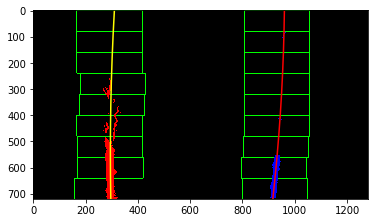

In [19]:
img = mpimg.imread('c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/test_images\\test5.jpg')
image,left_fitx,right_fitx, left_curverad, right_curverad, left_fit, right_fit, ploty ,left_fit_m,right_fit_m = fit_polynomial(img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='red')
plt.imshow(image)
print(len(left_fitx))
print("left curve is ",left_curverad)
print("right curve is ", right_curverad)

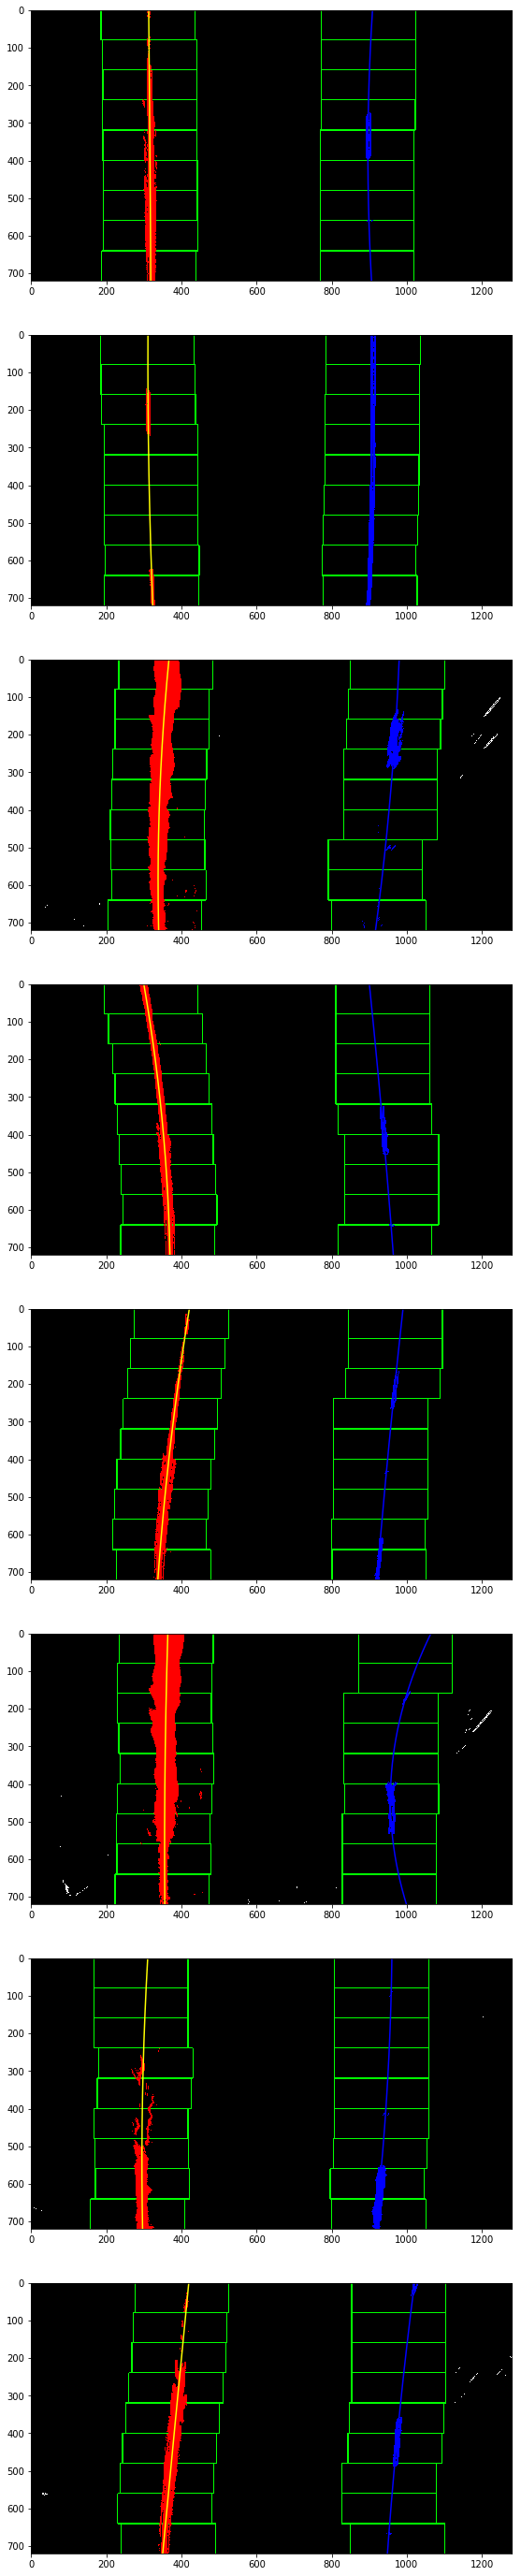

In [20]:
def test_sliding_window():
    """
    Inputs:
       None
    Outputs:
        Plot of lanes marked on activated binary image. It also shows sliding rectangles used for finding lanes.
    Functionality:
        This function tests fit_polynomial on given test images.
    """     
    images = []
    left_x = []
    right_x = []
    ploty_list = []
    for idx, fname in enumerate(test_img_given_glob):
        img = mpimg.imread(fname)
        image,left_fitx,right_fitx, left_curverad, right_curverad, left_fit, right_fit,ploty,left_fit_m,right_fit_m  = fit_polynomial(img)
        images.append(image)
        left_x.append(left_fitx)
        right_x.append(right_fitx)
        ploty_list.append(ploty)
    display_images_list_lane(images, left_x,right_x,ploty_list)
    

test_sliding_window() 

In [21]:
def draw_lane(img, left_fitx, right_fitx):
    """
    Inputs:
       img: Image with actiavted lanes marked on it.
       left_fitx: X-Coordinates for left lane
       right_fitx: X-Coordinates for right lane
    Outputs:
        Part of original image with lanes marked on it.
    Functionality:
        This function takes coordinates for left and right lanes, and then fill it with green color.
        It undo's the top-down view created earlier for lane marking and returns a portion of image
        which has lanes at its left and right end.
    """ 
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    #plt.imshow(img)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    #print(pts)
    #plt.imshow(color_warp)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]),flags=cv2.INTER_LINEAR) 
    return newwarp 

In [22]:
def get_vehicle_pos(img_shape,left_fit_m,right_fit_m ):
    """
    Inputs:
       img_shape: Shape of image
       left_fit_m: Equation Curvature of left lane with X and Y in meters
       right_fit_m: Equation Curvature of right lane with X and Y in meters
    Outputs:
        Position of car from center of image.
    Functionality:
        this function calculates position of car from center of lane. This needs curve of lanes in meters.
    """ 
    xMax = img_shape[1]*xm_per_pix
    yMax = img_shape[0]*ym_per_pix 
    vehicleCenter = xMax / 2
    
    left_fit = left_fit_m
    right_fit = right_fit_m

    
    lineLeft = left_fit[0]*yMax**2 + left_fit[1]*yMax + left_fit[2]
    lineRight = right_fit[0]*yMax**2 + right_fit[1]*yMax + right_fit[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    if diffFromVehicle > 0:
        pos = '{:.2f} m right'.format(diffFromVehicle)
    else:
        pos = '{:.2f} m left'.format(-diffFromVehicle)
    return pos

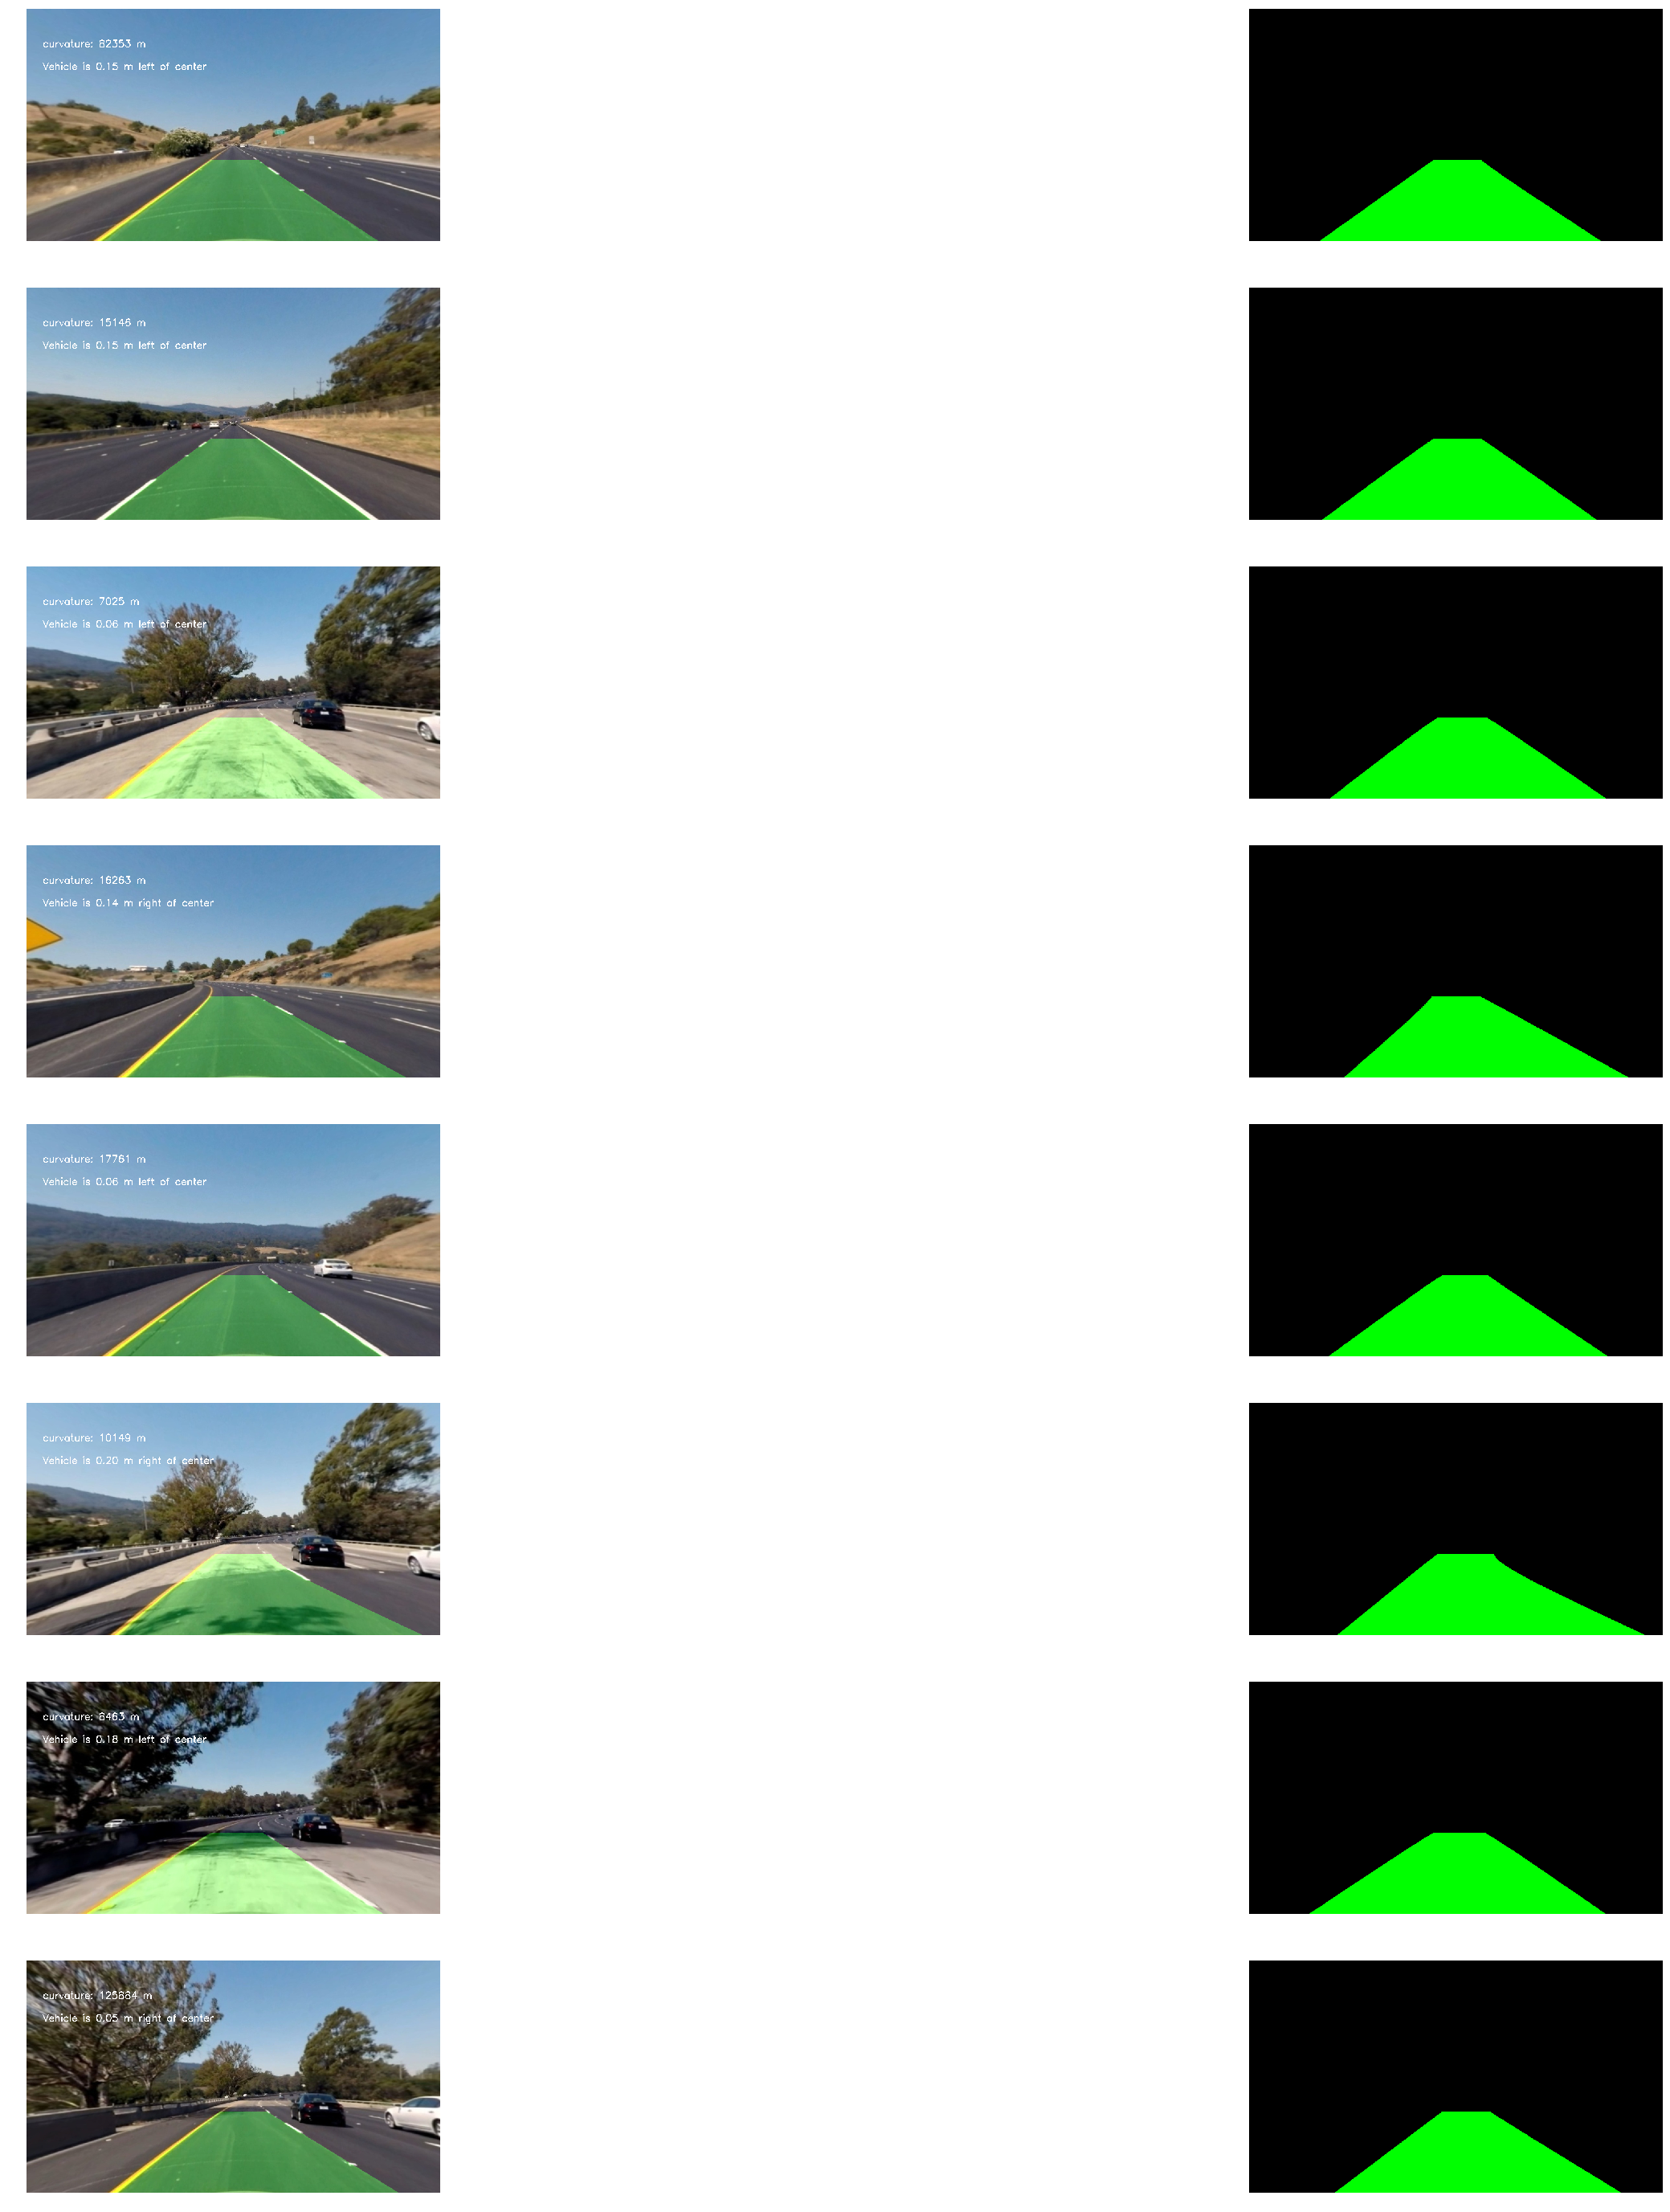

In [23]:
def test_draw_img_lane():
    """
    Inputs:
       None
    Outputs:
        Full processed image with proper lanes marked on it with position of car from center of lane.
    Functionality:
        This function tests draw_lane and get_vehicle_pos on given test images. This also checks end to end
        lane markings that is from given RGB image to RGB image with lanes marked on it.
    """ 
    images = []
    original_lane = []

    ploty_list = []
    for idx, fname in enumerate(test_img_given_glob):
        img = mpimg.imread(fname)
        image,left_fitx,right_fitx, left_curverad, right_curverad, left_fit, right_fit,ploty,left_fit_m,right_fit_m  = fit_polynomial(img)
        
        #print(image.shape)
        #print(len(left_fitx))
        #print(len(right_fitx))
        #print((left_fit))
        #print((right_fit))
        #print((ploty))
        #print("next")
        center = get_vehicle_pos(img.shape, left_fit_m,right_fit_m)
        
        updated_image = draw_lane(image,left_fitx, right_fitx )
        
        curve =  (left_curverad + right_curverad) /2
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontColor = (255, 255, 255)
        fontScale = 1
        cv2.putText(img, 'curvature: {:.0f} m'.format(curve), (50, 120), font, fontScale, fontColor, 2)
        cv2.putText(img, 'Vehicle is {} of center'.format(center), (50, 190), font, fontScale, fontColor, 2)
        
        image = cv2.addWeighted(img, 1, updated_image, 0.3, 0)
        
        images.append(image)
        original_lane.append(updated_image)
    all_img = images + original_lane
    display_iamges_list(all_img)

test_draw_img_lane()

In [24]:
def process_image(img):
    """
    Inputs:
       img: Image in RGB format, read from pipeline
    Outputs:
        Full processed image with proper lanes marked on it with position of car from center of lane.
    Functionality:
        This is from part-1 of project. Which takes a frame from view and process it through pipeline with 
        proper marking on given image.
    """
    image,left_fitx,right_fitx, left_curverad, right_curverad, left_fit, right_fit,ploty, left_fit_m,right_fit_m = fit_polynomial(img)
    
    center = get_vehicle_pos(img.shape, left_fit_m,right_fit_m)
        
    updated_image = draw_lane(image,left_fitx, right_fitx )
        
    curve =  (left_curverad + right_curverad) /2
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    fontScale = 1
    cv2.putText(img, 'curvature: {:.0f} m'.format(curve), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(img, 'Vehicle is {} of center'.format(center), (50, 190), font, fontScale, fontColor, 2)
        
    image = cv2.addWeighted(img, 1, updated_image, 0.3, 0)

    return image

In [25]:
white_output = proj_video_out
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(proj_video)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/output_images/project_video.mp4.
Moviepy - Writing video c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/output_images/project_video.mp4



Moviepy - Done !
Moviepy - video ready c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/output_images/project_video.mp4
Wall time: 3min


In [28]:
white_output = proj_challange_video_out
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(proj_challange_video)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)



Moviepy - Building video c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/output_images/challenge_video.mp4.
Moviepy - Writing video c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/output_images/challenge_video.mp4



t:   2%|█▏                                                                   | 8/485 [00:00<00:53,  8.98it/s, now=None]

got some error


t:   2%|█▎                                                                   | 9/485 [00:00<00:56,  8.41it/s, now=None]

got some error


t:   2%|█▍                                                                  | 10/485 [00:01<01:06,  7.15it/s, now=None]

got some error


t:   2%|█▌                                                                  | 11/485 [00:01<01:10,  6.75it/s, now=None]

got some error


t:  29%|███████████████████▍                                               | 141/485 [00:18<00:42,  8.04it/s, now=None]

got some error


Moviepy - Done !
Moviepy - video ready c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/output_images/challenge_video.mp4
Wall time: 1min 4s


In [29]:
white_output = proj_hard_challange_video_out
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(proj_hard_challange_video)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/output_images/harder_challenge_video.mp4.
Moviepy - Writing video c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/output_images/harder_challenge_video.mp4



t:  49%|████████████████████████████████▌                                 | 591/1199 [01:34<01:14,  8.12it/s, now=None]

got some error


t:  50%|█████████████████████████████████▏                                | 603/1199 [01:36<01:21,  7.32it/s, now=None]

got some error


t:  77%|██████████████████████████████████████████████████▊               | 922/1199 [02:33<00:35,  7.78it/s, now=None]

got some error


t:  77%|███████████████████████████████████████████████████               | 927/1199 [02:34<00:36,  7.40it/s, now=None]

got some error


t:  77%|███████████████████████████████████████████████████               | 928/1199 [02:34<00:36,  7.52it/s, now=None]

got some error


t:  84%|██████████████████████████████████████████████████████▌          | 1006/1199 [02:43<00:23,  8.24it/s, now=None]

got some error


t:  84%|██████████████████████████████████████████████████████▌          | 1007/1199 [02:44<00:23,  8.19it/s, now=None]

got some error


t:  84%|██████████████████████████████████████████████████████▋          | 1008/1199 [02:44<00:23,  8.07it/s, now=None]

got some error


t:  84%|██████████████████████████████████████████████████████▋          | 1009/1199 [02:44<00:23,  7.97it/s, now=None]

got some error


t:  84%|██████████████████████████████████████████████████████▊          | 1010/1199 [02:44<00:23,  7.94it/s, now=None]

got some error


t:  84%|██████████████████████████████████████████████████████▊          | 1011/1199 [02:44<00:23,  7.98it/s, now=None]

got some error


t:  84%|██████████████████████████████████████████████████████▊          | 1012/1199 [02:44<00:23,  7.82it/s, now=None]

got some error


Moviepy - Done !
Moviepy - video ready c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/output_images/harder_challenge_video.mp4
Wall time: 3min 16s


In [43]:
## Helper function to break video into frames. Need it for debugging

def conver_video_frames():
    vidObj_easy = cv2.VideoCapture("c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/output_images/project_video.mp4") 
    count = 0
    success = 1
    while success: 
        success, frame = vidObj_easy.read()
        cv2.imwrite("frame%d.jpg" % count, frame)
        count += 1
        
conver_video_frames()

In [31]:
vidObj_hard = cv2.VideoCapture("c:/Users/gasati/Documents/GitHub/Udacity_Self_Drive/Advanced_Lane_Lines/harder_challenge_video.mp4") 
count = 477
success, frame = vidObj_hard.read()
while success: 
    cv2.imwrite("frame%d.jpg" % count, frame)
    success, frame = vidObj_hard.read()
    count += 1


In [32]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty